In [1]:
import logging
import os
import sys
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').disabled = True
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

In [2]:
logging.basicConfig(level=1, format='[%(asctime)s %(levelname)s] %(message)s')
Option = namedtuple("MyStruct", "input model name folds batch_size epochs")
                    #structure learning_rate regularizer epochs")

In [3]:
from run_training import _build_model, _find_py_file

# K-Fold Validation
## Load and Split Data

In [4]:
args = Option(
    input='training1.h5',
    model='share/reference_number.py',
    name='NumberNetworkKFOLD',
    folds=10,
    batch_size=60,
    epochs=20,
    #learning_rate=0.0001,
    #regularizer=0.0001,
)
path = _find_py_file(args.model)

In [5]:
logging.info(f'Loading data from {args.input}')

with h5.File(args.input, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

labels = ['1particle', '2particle', '3particle']

[2020-07-08 01:13:27,382 INFO] Loading data from training1.h5


In [6]:
logging.info('Building model from %s', path)
model, compile_args, fit_args, params = _build_model(path, data_x, data_y)

[2020-07-08 01:13:39,185 INFO] Building model from share/reference_number.py


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
offset_and_scale (OffsetAndScal (None, 60)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 25)           1525        offset_and_scale[0][0]           
__________________________________________________________________________________________________
activation (Activation)         multiple             0           dense[0][0]                      
                                                                 dense_1[0][0]                

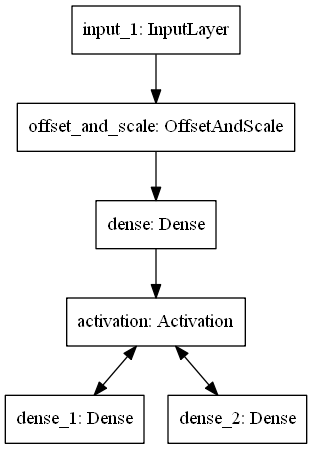

In [8]:
keras.utils.plot_model(model)

In [9]:
#FOR ITERATIVE TESTING QUICKER
#data_x = data_x[:5000]
#data_y = data_y[:5000]

In [10]:
models = []
#histories = []
#preds = []
#reals = []
fpr = {}
tpr = {}
auc1 = {}
acc_per_fold = []
loss_per_fold = []

#K-Fold Split Indices
kfold = KFold(n_splits=args.folds)
splits = kfold.split(data_x,data_y)

#dont forget to shuffle
data = np.concatenate([data_x, data_y], axis=1)
rng = np.random.default_rng(seed=42)
rng.shuffle(data)
data_x = data[:, 0:data_x.shape[1]]
data_y = data[:, data_x.shape[1]:data.shape[1]]

#
# To Do: Barrel and Endcap Layer Seperation
#

## Training and Validation

In [11]:
fold_no = 0
with h5.File(f'output/{args.name}.h5', 'w'):
    logging.info(f'output/{args.name}.h5 created/emptied')

for train, test in splits:
    fold_no += 1
    logging.info(f'Building model for fold {fold_no} from {path}...')
    model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
    compile_args['metrics']=['accuracy']
    fit_args['batch_size']=args.batch_size
    fit_args['validation_split'] = 0.1
    fit_args['epochs'] = args.epochs
    fit_args['callbacks'] = [keras.callbacks.TerminateOnNaN(),
                             keras.callbacks.ModelCheckpoint(args.name + str(fold_no) + '.h5', save_best_only=True,verbose=1)]
                             #keras.callbacks.CSVLogger('output/'+args.name+str(fold_no)+'.csv')]
    logging.info(f'Compiling for fold {fold_no} ...')
    model.compile(**compile_args)

    logging.info(f'Training for fold {fold_no} ...')
    history = model.fit(data_x[train], data_y[train], **fit_args)
    
    logging.info(f'Validating on fold {fold_no} ...')
    scores = model.evaluate(data_x[test], data_y[test])
    
    logging.info(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])
    
    logging.info(f'Calculating inference for fold {fold_no} ...')
    y_pred = model.predict(data_x[test])
    #preds.append(y_pred)
    #reals.append(data_y[test])
    
    for i, label in enumerate(labels):
        #print(f'{label}_{k+1}')
        #thisfpr, thistpr, threshold = roc_curve(data_y[test][:,i], y_pred[:,i])
        #fpr[label] = np.concatenate([fpr[label], thisfpr], axis=0)
        #tpr[label] = np.concatenate([tpr[label], thistpr], axis=0)
        fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'], threshold = roc_curve(data_y[test][:,i], y_pred[:,i])
        auc1[f'{label}_{fold_no}'] = auc(fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'])
        
    logging.info(f'Writing fit history to output/{args.name}.h5')
    with h5.File(f'output/{args.name}.h5', 'a') as hfile:
        for key, val in history.history.items():
            hfile.create_dataset(key+'_'+str(fold_no), data=np.array(val))
        for label in labels:
            hfile.create_dataset(f'{label}_{fold_no}_fpr', data=fpr[f'{label}_{fold_no}'])
            hfile.create_dataset(f'{label}_{fold_no}_tpr', data=tpr[f'{label}_{fold_no}'])
            hfile.create_dataset(f'{label}_{fold_no}_auc', data=auc1[f'{label}_{fold_no}'])
    models.append(model)

logging.info('Done training!')

'''
fpr_dict = {}
tpr_dict = {}
for i,label in enumerate(labels):
    #print(f'{label}_{k+1}')
    fpr_dict[label] = np.array([])
    tpr_dict[label] = np.array([])
    for k in range(fold_no):
        #print(k)
        fpr_dict[label] = np.concatenate([fpr_dict[label], fpr[label+f'_{k+1}']], axis=0)
        tpr_dict[label] = np.concatenate([tpr_dict[label], tpr[label+f'_{k+1}']], axis=0)
'''

[2020-07-08 01:14:03,767 INFO] output/NumberNetworkKFOLD.h5 created/emptied
[2020-07-08 01:14:03,863 INFO] Building model for fold 1 from share/reference_number.py...
[2020-07-08 01:14:07,281 INFO] Compiling for fold 1 ...
[2020-07-08 01:14:07,294 INFO] Training for fold 1 ...
Epoch 1/20
158563/158602 [============================>.] - ETA: 0s - loss: 0.5689 - accuracy: 0.7438
Epoch 00001: val_loss improved from inf to 0.53643, saving model to NumberNetworkKFOLD1.h5
158602/158602 [==============================] - 140s 885us/step - loss: 0.5689 - accuracy: 0.7438 - val_loss: 0.5364 - val_accuracy: 0.7624
Epoch 2/20
 73549/158602 [============>.................] - ETA: 1:10 - loss: 0.5256 - accuracy: 0.7656

KeyboardInterrupt: 

In [28]:
with h5.File('output/NumberNetworkKFOLD.h5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['1particle_0_auc', '1particle_0_fpr', '1particle_0_tpr', '1particle_1_auc', '1particle_1_fpr', '1particle_1_tpr', '1particle_2_auc', '1particle_2_fpr', '1particle_2_tpr', '1particle_3_auc', '1particle_3_fpr', '1particle_3_tpr', '1particle_4_auc', '1particle_4_fpr', '1particle_4_tpr', '1particle_5_auc', '1particle_5_fpr', '1particle_5_tpr', '1particle_6_auc', '1particle_6_fpr', '1particle_6_tpr', '1particle_7_auc', '1particle_7_fpr', '1particle_7_tpr', '1particle_8_auc', '1particle_8_fpr', '1particle_8_tpr', '2particle_0_auc', '2particle_0_fpr', '2particle_0_tpr', '2particle_1_auc', '2particle_1_fpr', '2particle_1_tpr', '2particle_2_auc', '2particle_2_fpr', '2particle_2_tpr', '2particle_3_auc', '2particle_3_fpr', '2particle_3_tpr', '2particle_4_auc', '2particle_4_fpr', '2particle_4_tpr', '2particle_5_auc', '2particle_5_fpr', '2particle_5_tpr', '2particle_6_auc', '2particle_6_fpr', '2particle_6_tpr', '2particle_7_auc', '2particle_7_fpr', '2particle_7_tpr', '2particle_8_auc

## Plotting and Evaluation

# ROC Curves

In [ ]:
f = h5.File(f'output/{args.name}.h5')

In [26]:
def kfoldRoc(infile, labels):
    #fpr, tpr, auc, labels, name='', outdir='output/'
    fpr_list = []
    tpr_list = []
    auc_list = []
    with h5.File(infile, 'r') as hfile:
        for label in labels:
            for i in range(fold_no):
                fpr_list.append(hfile[f'{label}_{i+1}_fpr'][()])
                tpr_list.append(hfile[f'{label}_{i+1}_tpr'][()])
                auc_list.append(hfile[f'{label}_{i+1}_auc'][()])
        print(len(fpr_list))

    plt.figure()
    for label in labels:
        fpr_avgs = np.array([])
        tpr_avgs = np.array([])
        for i in range(len(fpr_list[0])): # revise to go through every sample, 
            fpr_vals = np.array([]) #one row of each kfold fpr
            tpr_vals = np.array([])
            for k in range(fold_no-1):
                fpr_vals = fpr_list[k][i]
                tpr_vals = tpr_list[k][i]
            fpr_avgs = np.concatenate([fpr_avgs, [np.mean(fold_vals)]], axis=0)
            tpr_avgs = np.concatenate([tpr_avgs, [np.mean(fold_vals)]], axis=0)
        #plt.plot(fpr[label][()],tpr[label][()],
        plt.plot(fpr_avgs, tpr_avgs,
                 label=f'{label} (AUC = {np.mean(auc1[label][()]):.2f} (+- {np.std(auc1[label][()]):.4f})')
    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,f'{name}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig(f'{outdir}{name}_ROC.pdf')
    plt.close()

In [27]:
kfoldRoc(f'output/{args.name}.h5', labels)

KeyError: "Unable to open object (object '1particle_9_fpr' doesn't exist)"

In [21]:
print('---Average scores---')
print('Score per fold')
for i in range(0,len(acc_per_fold)):
    print(f'Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {acc_per_fold[i]:.2f}%')
print('--------------------')
print('Average scores for all folds:')
print(f'Accuracy: {np.mean(acc_per_fold):.2f} (+- {np.std(acc_per_fold):.4f})')
print(f'Loss: {np.mean(loss_per_fold):.4f} (+- {np.std(loss_per_fold):.4f})')
print('---Average AUC------')
for label in labels:
    for i in range(fold_no-1):
        print(f'Fold {i+1} - {label} - AUC: {auc1[label][i]*100:.2f}')
        
print('--------------------')
print('Average AUC for all folds:')
for label in labels:
    print(f'{label} - AUC: {np.mean(auc1[label]):.2f} (+- {np.std(auc1[label]):.4f})')

---Average scores---
Score per fold
Fold 1 - Loss: 0.0009 - Accuracy: 100.00%
Fold 2 - Loss: 0.0009 - Accuracy: 100.00%
Fold 3 - Loss: 0.0009 - Accuracy: 100.00%
Fold 4 - Loss: 0.0009 - Accuracy: 100.00%
Fold 5 - Loss: 0.0009 - Accuracy: 100.00%
Fold 6 - Loss: 0.0008 - Accuracy: 100.00%
Fold 7 - Loss: 0.0008 - Accuracy: 100.00%
Fold 8 - Loss: 0.0008 - Accuracy: 100.00%
Fold 9 - Loss: 0.0009 - Accuracy: 100.00%
Fold 10 - Loss: 0.0009 - Accuracy: 100.00%
--------------------
Average scores for all folds:
Accuracy: 100.00 (+- 0.0000)
Loss: 0.0009 (+- 0.0000)
---Average AUC------
Fold 1 - 1particle - AUC: nan
Fold 2 - 1particle - AUC: nan
Fold 3 - 1particle - AUC: nan
Fold 4 - 1particle - AUC: nan
Fold 5 - 1particle - AUC: nan
Fold 6 - 1particle - AUC: nan
Fold 7 - 1particle - AUC: nan
Fold 8 - 1particle - AUC: nan
Fold 1 - 2particle - AUC: nan
Fold 2 - 2particle - AUC: nan
Fold 3 - 2particle - AUC: nan
Fold 4 - 2particle - AUC: nan
Fold 5 - 2particle - AUC: nan
Fold 6 - 2particle - AUC: n

In [125]:
fpr_avgs = np.array([])
for i in range(len(fpr_list[0])):
    fold_vals = np.array([])
    for k in range(fold_no-1):
        fold_vals = fpr_list[k][i]
    fpr_avgs = np.concatenate([fpr_avgs, [np.mean(fold_vals)]], axis=0)

In [10]:
f = h5.File('roc_vals.h5', 'r')

In [11]:
f.keys()

<KeysViewHDF5 ['auc', 'fpr', 'tpr']>

In [59]:
f['auc'].keys()

<KeysViewHDF5 ['1particle', '2particle', '3particle']>

In [86]:
f['fpr']['1particle'][()].shape

(2206934,)

In [121]:
fpr_list = list(chunks(f['fpr']['1particle'][()], int(f['fpr']['1particle'][()].shape[0]/10))) 
#should have saved fpr for each fold

In [123]:
fpr_list[0][220000]

0.007662695786454886

In [124]:
len(fpr_list)

11

In [131]:
tpr_list = list(chunks(f['tpr']['1particle'][()], int(f['tpr']['1particle'][()].shape[0]/10)))

In [132]:
tpr_avgs = np.array([])
for i in range(len(tpr_list[0])):
    fold_vals = np.array([])
    for k in range(fold_no-1):
        fold_vals = tpr_list[k][i]
    tpr_avgs = np.concatenate([tpr_avgs, [np.mean(fold_vals)]], axis=0)

C:\Users\alexc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.
[2020-07-06 11:01:05,825 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:05,825 DEBUG] ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02])
[2020-07-06 11:01:05,837 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:05,838 DEBUG] ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02])
[2020-07-06 11:01:05,841 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:05,842 DEBUG] ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02])
[2020-07-06 11:01:05,844 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:05,845 DEBUG] ticklocs array([2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-

[2020-07-06 11:01:06,136 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:06,137 DEBUG] ticklocs array([2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
[2020-07-06 11:01:06,146 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:06,147 DEBUG] ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00

[2020-07-06 11:01:06,359 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:06,359 DEBUG] ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02])
[2020-07-06 11:01:06,361 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:06,362 DEBUG] ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02])
[2020-07-06 11:01:06,363 DEBUG] vmin 2.379756798279619e-06 vmax 1.05
[2020-07-06 11:01:06,364 DEBUG] ticklocs array([2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01,

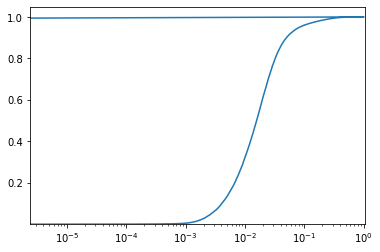

In [146]:
plt.figure()
plt.plot(fpr_avgs, tpr_avgs)
plt.semilogx()
plt.xlim([-0.05, 1.05])
plt.ylim(0.001,1.05)
plt.show()
plt.close()

KeyboardInterrupt: 

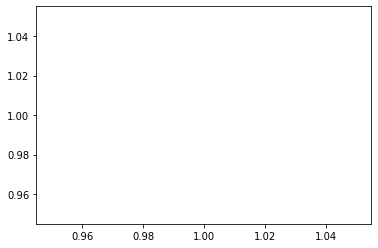

In [160]:
kfoldRoc(f['fpr'], f['tpr'], f['auc'], labels=labels, name='K-Fold_20_Epochs', outdir = 'output/')

In [172]:
f = h5.File('roc_vals.h5', 'r')

In [173]:
g = h5.File('roc_vals.h5', 'r')

In [174]:
h = h5.File('roc_vals.h5', 'w')

OSError: Unable to create file (unable to truncate a file which is already open)

In [51]:
f.close()

In [ ]:
#df = pd.DataFrame()
#fpr = {}
#tpr = {}
#auc1 = {}
#y_pred = model.predict(data_x[test])
#for i, label in enumerate(labels):
#    fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'], threshold = roc_curve(data_y[test][:,i], y_pred[:,i])
#    auc1[f'{label}_{fold_no}'] = auc(fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'])

In [ ]:
#fpr_dict = {}

In [ ]:
#for i,label in enumerate(labels):
#    print(f'{label}_{k+1}')
#    fpr_dict[label] = np.array([])
#    for k in range(fold_no):
#        print(k)
#        fpr_dict[label] = np.concatenate([fpr_dict[label], fpr[label+f'_{k+1}']], axis=0)